In [1]:
import pandas as pd
import numpy as np
import requests as req
import datetime as dt
import time
from scipy.stats import norm, binom
import statsmodels.api as sm

__Pet проект__. 

Данная тетрадь представляет из себя набор функций на основании которых можно составить стратегию для торгового бота. 

Представлены функции для загрузки данных с Московской биржи:
- Цены акции
- Индекс MOEX
- Кривая бескупонной доходности

Представлены функции для расчета:
- бета коэффициента
- альфа коэффициента
- event study


# Загрузка данных

__Константы для функций__

In [2]:
# Определение констант 
SECID = 'SBER'
INDEXID = 'IMOEX'
END_DATE = dt.datetime.today().strftime('%Y-%m-%d') # Окно заканчивается сегодняшней ценой закрытия
START_DATE = (dt.datetime.today() - dt.timedelta(days=365)).strftime('%Y-%m-%d') #Окно начинается год назад
EVENT_DATE = (dt.datetime.today() - dt.timedelta(days=10)).strftime('%Y-%m-%d')  # Дата события 10 дней назад

## Загрузка данных акций

Для загрузки данных с API применяются три основные функции:
__flatten__, __get_moex_stock_data__, __get_moex_data_and_prepare__

### Описание функций

__- flatten__ используется для преобразования вложенного JSON-объекта, полученного из MOEX API, в плоский список словарей. 

Применяется в других методах получения данных

Параметры:

- j (dict): JSON-объект, полученный из MOEX API. Этот объект должен содержать блок данных с определёнными столбцами и значениями.
- blockname (str): Имя ключа в JSON-объекте, который содержит необходимые данные. Обычно этот ключ указывает на блок данных, например, “history”.

__- Функция get_moex_stock_data__ Функция возвращает список словарей, где каждый словарь представляет одну запись с данными о ценах акций.

Параметры:

- secid (str): Идентификатор ценной бумаги.
- start_date (str or datetime.date): Начальная дата в формате “YYYY-MM-DD” или объект datetime.date.
- end_date (str or datetime.date): Конечная дата в формате “YYYY-MM-DD” или объект datetime.date.
- engine (str): Движок рынка. По умолчанию ‘stock’.
- market (str): Рынок. По умолчанию ‘shares’.
- board (str): Торговая площадка. По умолчанию ‘TQBR’.

__- get_moex_data_and_prepare__ - извлекает данные о ценах акций с MOEX API за заданный период времени.

Параметры:

- secid (str): Идентификатор ценной бумаги.
- start_date (str or datetime.date): Начальная дата в формате “YYYY-MM-DD” или объект datetime.date.
- end_date (str or datetime.date): Конечная дата в формате “YYYY-MM-DD” или объект datetime.date.

Функция использует __get_moex_stock_data__ для получения данных и преобразует их в DataFrame с ценами акций и доходностью.

### Функции

In [3]:
# Функция для извлечения данных с JSON объекта
def flatten(j: dict, blockname: str):
    columns = j[blockname]['columns']
    return [{k: r[I] for I, k in enumerate(columns)} for r in j[blockname]['data']]

# Функция для запроса тикера и извлечения данных с JSON объекта
def get_moex_stock_data(secid, start_date, end_date, engine='stock', market='shares', board='TQBR'):
    # Преобразование дат в объекты datetime, если они являются строками
    if isinstance(start_date, str):
        start_date = dt.datetime.strptime(start_date, "%Y-%m-%d").date()
    if isinstance(end_date, str):
        end_date = dt.datetime.strptime(end_date, "%Y-%m-%d").date()

    all_data = []
    current_start_date = start_date

    while current_start_date <= end_date:
        current_end_date = current_start_date + dt.timedelta(days=99)
        if current_end_date > end_date:
            current_end_date = end_date

        # Запрос к MOEX
        url = f"https://iss.moex.com/iss/history/engines/{engine}/markets/{market}/boards/{board}/securities/{secid}.json?from={current_start_date}&till={current_end_date}&iss.meta=off"
        try:
            r = req.get(url)
            r.encoding = 'utf-8'
            j = r.json()

            # Преобразование ответа и добавление данных в список all_data
            flattened_data = flatten(j, 'history')
            all_data.extend(flattened_data)

            # Переход к следующему периоду
            current_start_date = current_end_date + dt.timedelta(days=1)

            # Добавление задержки, чтобы избежать отправки слишком большого количества запросов за короткий период
            time.sleep(1)

        except req.exceptions.RequestException as e:
            print(f"Запрос не удался: {e}")
            break

    return all_data

# Функция для обработки данных и упрощения данных
def get_moex_data_and_prepare(secid, start_date, end_date):
    data = get_moex_stock_data(secid, start_date, end_date)
    df = pd.DataFrame(data)
    df['TRADEDATE'] = pd.to_datetime(df['TRADEDATE'])
    df.set_index('TRADEDATE', inplace=True)
    df = df[['CLOSE']].asfreq("B").fillna(method='ffill')
    df.columns = [f'{secid}_Stock_Price']
    
    # Добавление столбца с доходностью и удаление первой строки
    df[f'{secid}_Daily_Return'] = df[f'{secid}_Stock_Price'].pct_change()
    df.dropna(inplace=True)
    
    return df

### Пример использования

In [4]:
ticker_df = get_moex_data_and_prepare(SECID, START_DATE, END_DATE)

In [5]:
ticker_df.tail(10)

,SBER_Stock_Price,SBER_Daily_Return
TRADEDATE,,
2024-07-08,324.07,-0.002862
2024-07-09,319.99,-0.012590
2024-07-10,316.68,-0.010344
2024-07-11,295.87,-0.065713
2024-07-12,292.21,-0.012370
2024-07-15,284.38,-0.026796
2024-07-16,285.25,0.003059
2024-07-17,284.68,-0.001998
2024-07-18,289.83,0.018090


## Загрузка данных индекса 

### Описание функций

__- get_moex_index_data__ возвращает список словарей, где каждый словарь представляет одну запись с данными об индексах.

Параметры:

- indexid (str): Идентификатор индекса.
- start_date (str or datetime.date): Начальная дата в формате “YYYY-MM-DD” или объект datetime.date.
- end_date (str or datetime.date): Конечная дата в формате “YYYY-MM-DD” или объект datetime.date.
- engine (str): Движок рынка. По умолчанию ‘stock’.
- market (str): Рынок. По умолчанию ‘index’.
- board (str): Торговая площадка. По умолчанию ‘SNDX’.

__- get_moex_index_data_and_prepare__ - извлекает данные о котировках индекса из словаря за заданный период времени.

Параметры:

- indexid (str): Идентификатор индекса.
- start_date (str or datetime.date): Начальная дата в формате “YYYY-MM-DD” или объект datetime.date.
- end_date (str or datetime.date): Конечная дата в формате “YYYY-MM-DD” или объект datetime.date.

Функция использует __get_moex_index_data__ для получения данных и преобразует их в DataFrame с ценами индекса и доходностью.

### Функции 

In [6]:
def get_moex_index_data(indexid, start_date, end_date, engine='stock', market='index', board='SNDX'):
    # Преобразование дат в объекты datetime, если они являются строками
    if isinstance(start_date, str):
        start_date = dt.datetime.strptime(start_date, "%Y-%m-%d").date()
    if isinstance(end_date, str):
        end_date = dt.datetime.strptime(end_date, "%Y-%m-%d").date()

    all_data = []
    current_start_date = start_date

    while current_start_date <= end_date:
        current_end_date = current_start_date + dt.timedelta(days=99)
        if current_end_date > end_date:
            current_end_date = end_date

        # Запрос к MOEX
        url = f"https://iss.moex.com/iss/history/engines/{engine}/markets/{market}/boards/{board}/securities/{indexid}.json?from={current_start_date}&till={current_end_date}&iss.meta=off"
        try:
            r = req.get(url)
            r.encoding = 'utf-8'
            j = r.json()

            # Преобразование ответа и добавление данных в список all_data
            flattened_data = flatten(j, 'history')
            all_data.extend(flattened_data)

            # Переход к следующему периоду
            current_start_date = current_end_date + dt.timedelta(days=1)

            # Добавление задержки, чтобы избежать отправки слишком большого количества запросов за короткий период
            time.sleep(1)

        except req.exceptions.RequestException as e:
            print(f"Запрос не удался: {e}")
            break

    return all_data

# Функция для получения данных MOEX и их подготовки
def get_moex_index_data_and_prepare(indexid, start_date, end_date):
    data = get_moex_index_data(indexid, start_date, end_date)
    df = pd.DataFrame(data)
    df['TRADEDATE'] = pd.to_datetime(df['TRADEDATE'])
    df.set_index('TRADEDATE', inplace=True)
    df = df[['CLOSE']].asfreq("B").fillna(method='ffill')
    df.columns = [f'{indexid}_Index_Price']
    
    # Добавление столбца с доходностью и удаление первой строки
    df[f'{indexid}_Daily_Return'] = df[f'{indexid}_Index_Price'].pct_change()
    df.dropna(inplace=True)
    
    return df

### Пример использования

In [7]:
# Пример использования функции для индекса IMOEX
index_df = get_moex_index_data_and_prepare(INDEXID, START_DATE, END_DATE)

In [8]:
index_df.tail(10)

,IMOEX_Index_Price,IMOEX_Daily_Return
TRADEDATE,,
2024-07-09,3054.07,-0.025062
2024-07-10,2975.75,-0.025644
2024-07-11,2992.21,0.005531
2024-07-12,2973.21,-0.006350
2024-07-15,2913.48,-0.020089
2024-07-16,2944.86,0.010771
2024-07-17,2947.24,0.000808
2024-07-18,2980.62,0.011326
2024-07-19,3008.24,0.009267


## Загрузка безрисоквой ставки

### Описание функций

__get_rf_moex__ используется для получения данных о безрисковой ставке с MOEX API на заданную дату.

Параметры:

- date (str or datetime.date): Дата запроса в формате “YYYY-MM-DD” или объект datetime.date.
- engine (str): Движок рынка. По умолчанию ‘stock’.

__get_risk_free_rate__ используется для извлечения значения безрисковой ставки на заданную дату и для заданного периода с MOEX API.

Параметры:

- date (str or datetime.date): Дата запроса в формате “YYYY-MM-DD” или объект datetime.date.
- period (float): Период безрисковой ставки в годах. По умолчанию 1.0.


### Функции

In [9]:
def get_rf_moex(date, engine='stock'):
    if isinstance(date, str):
        date = dt.datetime.strptime(date, "%Y-%m-%d").date()
    
    url = f"https://iss.moex.com/iss/engines/{engine}/zcyc.json?date={date}&iss.meta=off"
    
    try:
        r = req.get(url)
        if r.status_code != 200:
            print(f"HTTP Error: {r.status_code}")
            return None
        
        r.encoding = 'utf-8-sig'
        j = r.json()
        return j

    except req.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        return None

def get_risk_free_rate(date, period=1.0):
    response_json = get_rf_moex(date)
    if not response_json:
        return None
    
    yearyields_data = response_json.get('yearyields', {})
    columns = yearyields_data.get('columns', [])
    data = yearyields_data.get('data', [])
    
    for row in data:
        yield_info = {columns[i]: row[i] for i in range(len(columns))}
        if yield_info.get('period') == period:
            return round(yield_info.get('value') / 100,3)
    
    return None

### Пример использования

In [10]:
risk_free_rate = get_risk_free_rate('2024-06-06')
print(f"Risk-free rate on for 1 year: {risk_free_rate}")

Risk-free rate on for 1 year: 0.159


# Событийный анализ

## Расчет метрик alpha & beta

### Описание функций

__calculate_beta__ используется для расчета бета коэффициента, который измеряет чувствительность доходности акций относительно доходности рыночного индекса.

Параметры:

- ticker_df (pd.DataFrame): DataFrame с данными о ценах акций, включая дневную доходность.
- index_df (pd.DataFrame): DataFrame с данными об индексе, включая дневную доходность.
- ticker_id (str): Идентификатор ценной бумаги.
- index_id (str): Идентификатор индекса.
- window (int): Окно для расчета бета коэффициента в днях. По умолчанию 90.

Функция объединяет данные акций и индекса, берет последние данные в указанном окне и использует линейную регрессию для расчета бета коэффициента.

__calculate_alpha__ используется для расчета альфа коэффициента, который измеряет избыточную доходность акций по сравнению с ожидаемой доходностью, рассчитанной на основе бета коэффициента.

Параметры:

- ticker_df (pd.DataFrame): DataFrame с данными о ценах акций, включая дневную доходность.
- index_df (pd.DataFrame): DataFrame с данными об индексе, включая дневную доходность.
- ticker_id (str): Идентификатор ценной бумаги.
- index_id (str): Идентификатор индекса.
- beta (float): Предварительно рассчитанный бета коэффициент для ценной бумаги.
- risk_free_rate (float): Безрисковая ставка доходности. По умолчанию 0.0.
- window (int): Окно для расчета альфа коэффициента в днях. По умолчанию 90.

Функция объединяет данные акций и индекса, берет последние данные в указанном окне, вычисляет среднюю доходность акций и индекса, и на основе этих данных рассчитывает альфа коэффициент.


### Функции

In [11]:
# Функция для расчета бета коэффициента
def calculate_beta(ticker_df, index_df, ticker_id, index_id, window=90):
    # Объединение данных на основе даты
    merged_df = pd.merge(ticker_df, index_df, left_index=True, right_index=True, suffixes=('_ticker', '_index'))

    # Взятие только последних данных в окне
    returns_ticker = merged_df[f'{ticker_id}_Daily_Return'].tail(window)
    returns_index = merged_df[f'{index_id}_Daily_Return'].tail(window)

    # Добавление константы для выполнения линейной регрессии
    X = sm.add_constant(returns_index)

    # Создание и подгонка модели
    model = sm.OLS(returns_ticker, X).fit()

    # Извлечение бета коэффициента
    beta = model.params[1]

    return beta

# Функция для расчета альфа коэффициента с использованием безрисковой ставки доходности
def calculate_alpha(ticker_df, index_df, ticker_id, index_id, beta, window=90):
    # Объединение данных на основе даты
    merged_df = pd.merge(ticker_df, index_df, left_index=True, right_index=True, suffixes=('_ticker', '_index'))

    # Взятие только последних данных в окне
    returns_ticker = merged_df[f'{ticker_id}_Daily_Return'].tail(window)
    returns_index = merged_df[f'{index_id}_Daily_Return'].tail(window)

    # Средняя доходность акций и индекса
    mean_ticker_return = returns_ticker.mean()
    mean_index_return = returns_index.mean()

    # Получение безрисковой ставки доходности
    risk_free_rate = get_risk_free_rate(returns_ticker.index[-1]) 

    if risk_free_rate is None:
        print("Не удалось получить безрисковую ставку доходности")
        return None

    # Расчет альфа коэффициента
    alpha = mean_ticker_return - beta * (mean_index_return - risk_free_rate)

    return alpha

### Пример использования

__Бета-коэффициент__

- __Бета__ Коэффициент наклона линии регрессии, показывающий чувствительность доходности актива к доходности рынка.


- __beta__ = 1: Доходность актива изменяется в точности как доходность рынка. Актив имеет средний рыночный риск.
- __beta__ > 1: Актив более волатильный и рискованный по сравнению с рынком. Например, __beta__ = 1.5 означает, что если рынок вырастет на 1%, доходность актива вырастет на 1.5%, и наоборот.
- __beta__ < 1: Актив менее волатильный и менее рискованный по сравнению с рынком. Например, __beta__ = 0.5 означает, что если рынок вырастет на 1%, доходность актива вырастет на 0.5%, и наоборот.
- __beta__ = 0: Доходность актива не зависит от доходности рынка. Такие активы имеют минимальный рыночный риск.
- __beta__ < 0: Актив движется в противоположном направлении от рынка. Например, __beta__ = -1 означает, что если рынок вырастет на 1%, доходность актива упадет на 1%, и наоборот.

__Альфа-коэффициент__

- __Альфа__ Интерсепт, показывающий избыточную доходность актива после учета влияния рынка.


- __alpha__ > 0: Актив обеспечивает избыточную доходность по сравнению с ожидаемой доходностью на основе его риска. Это указывает на превосходную управленческую эффективность.
- __alpha__ = 0: Актив обеспечивает доходность, соответствующую ожидаемой доходности на основе его риска. Это указывает на то, что актив работает так, как предсказывается моделью.
- __alpha__ < 0: Актив обеспечивает доходность ниже ожидаемой на основе его риска. Это указывает на недостаточную управленческую эффективность.

In [12]:
# Проверка для расчета коэффициента бета
beta = calculate_beta(ticker_df, index_df, SECID, INDEXID, window=90)

# Проверка для расчета коэффициента альфа
alpha = calculate_alpha(ticker_df, index_df, SECID, INDEXID, beta, window=90)

print("Бета коэффициент:", round(beta,3))
print("Альфа коэффициент:", round(alpha,3))

Бета коэффициент: 0.547
Альфа коэффициент: 0.09


## Событийный анализ (Event study)

### Описание функции

__event_study__ используется для проведения исследования событий (event study), которое анализирует влияние определенного события на цены акций.

Параметры:

- ticker_id (str): Идентификатор ценной бумаги.
- index_id (str): Идентификатор индекса.
- event_date (datetime.date): Дата события.
- estimation_window (int): Окно оценки в днях до события. По умолчанию 90.
- event_window (int): Окно события в днях до и после даты события. По умолчанию 10.

Функция извлекает данные о ценах акций и индекса за период, включающий окна оценки и события, рассчитывает бета и альфа коэффициенты на основе окна оценки (до события), и вычисляет нормальную и аномальную доходность акций в окне события. Возвращает аномальную доходность и кумулятивную аномальную доходность (CAR).

### Функции:

In [13]:
def event_study(ticker_id, index_id, event_date, estimation_window=90, event_window=5):
    event_date = dt.datetime.strptime(event_date, '%Y-%m-%d').date()
    start_date = (event_date - dt.timedelta(days=estimation_window + event_window)).strftime('%Y-%m-%d')
    end_date = (event_date + dt.timedelta(days=event_window)).strftime('%Y-%m-%d')
    ticker_df = get_moex_data_and_prepare(ticker_id, start_date, end_date)
    index_df = get_moex_index_data_and_prepare(index_id, start_date, end_date)
    
    # Определение периода оценки и периода события
    estimation_df = ticker_df[:event_date].tail(estimation_window)
    event_df = ticker_df[event_date - dt.timedelta(days=event_window):event_date + dt.timedelta(days=event_window)]
    
    index_estimation_df = index_df[:event_date].tail(estimation_window)
    index_event_df = index_df[event_date - dt.timedelta(days=event_window):event_date + dt.timedelta(days=event_window)]
    
    # Расчет бета и альфа коэффициентов
    beta = calculate_beta(estimation_df, index_estimation_df, ticker_id, index_id, window=estimation_window) 
    alpha = calculate_alpha(estimation_df, index_estimation_df, ticker_id, index_id, beta, window=estimation_window)
    
    # Расчет нормальной и аномальной доходности
    normal_returns = alpha + beta * index_event_df[f'{index_id}_Daily_Return']
    abnormal_returns = event_df[f'{ticker_id}_Daily_Return'] - normal_returns
    
    # Расчет кумулятивной аномальной доходности (CAR)
    CAR = abnormal_returns.cumsum()
    
    # Создание DataFrame с результатами
    results_df = pd.DataFrame({
        'Actual_Return': event_df[f'{ticker_id}_Daily_Return'],
        'Predicted_Return': normal_returns,
        'Abnormal_Return': abnormal_returns,
        'CAR': CAR})
    
    results_df.index.name = 'Date'
    
    return results_df, beta, alpha, estimation_df

### Пример использования

In [14]:
results_df, beta, alpha, estimation_df = event_study(SECID, INDEXID, EVENT_DATE)
display(results_df.tail(10))
print(f"Бета коэффициент: {beta}")
print(f"Альфа коэффициент: {alpha}")

,Actual_Return,Predicted_Return,Abnormal_Return,CAR
Date,,,,
2024-07-08,-0.002862,0.077050,-0.079912,-0.079912
2024-07-09,-0.012590,0.067490,-0.080080,-0.159992
2024-07-10,-0.010344,0.067209,-0.077553,-0.237545
2024-07-11,-0.065713,0.082294,-0.148007,-0.385552
2024-07-12,-0.012370,0.076545,-0.088915,-0.474467
2024-07-15,-0.026796,0.069897,-0.096693,-0.571159
2024-07-16,0.003059,0.084829,-0.081770,-0.652929
2024-07-17,-0.001998,0.080008,-0.082007,-0.734936


Бета коэффициент: 0.4838681465034941
Альфа коэффициент: 0.0796173517026182


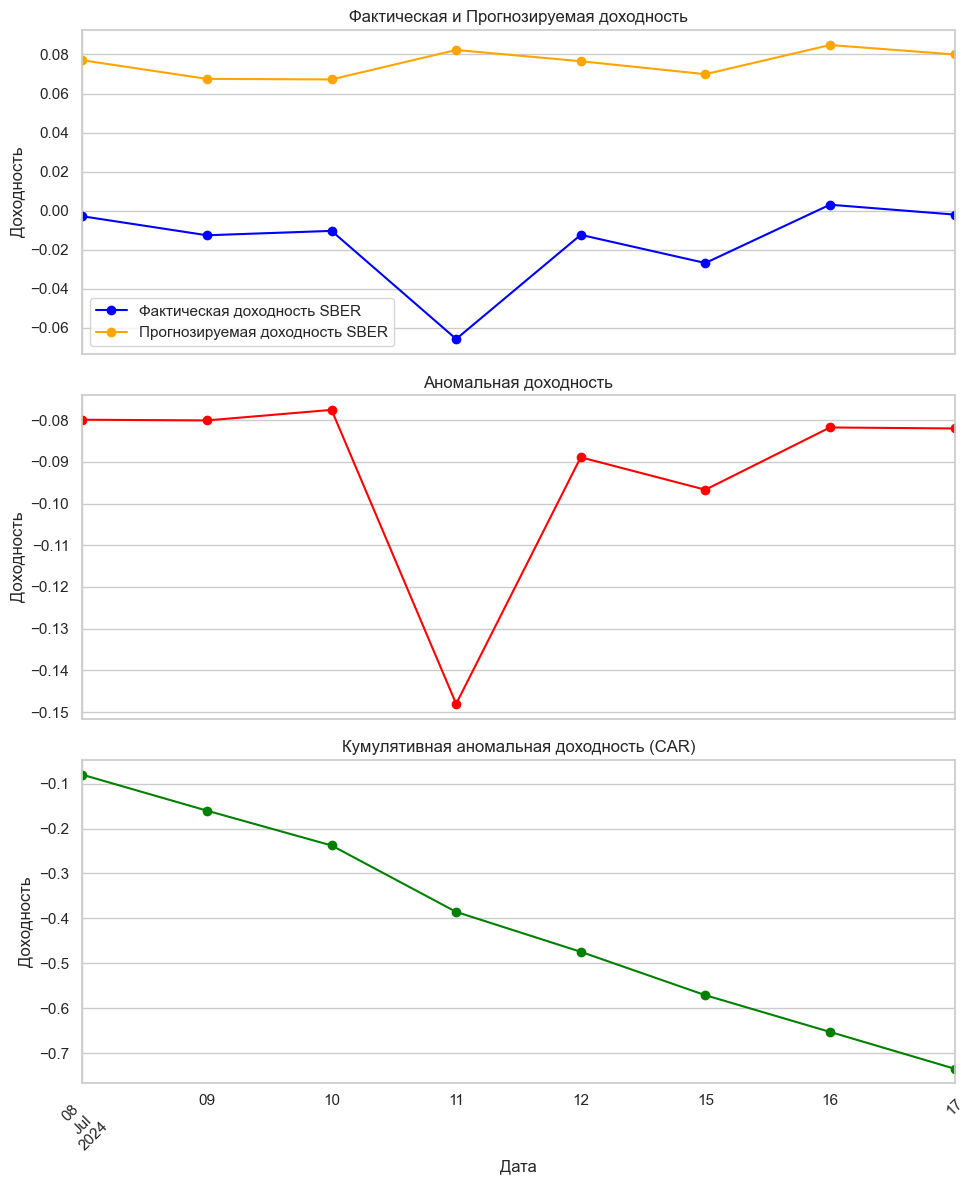

In [22]:
# Установка стиля графика
sns.set(style="whitegrid")

# Создание подграфиков
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Построение графиков
# Объединенный график фактической и прогнозируемой доходности
results_df['Actual_Return'].plot(ax=axs[0], marker='o', color='blue', label=f'Фактическая доходность {SECID}')
results_df['Predicted_Return'].plot(ax=axs[0], marker='o', color='orange', label=f'Прогнозируемая доходность {SECID}')
axs[0].set_title('Фактическая и Прогнозируемая доходность')
axs[0].legend()

# График аномальной доходности
results_df['Abnormal_Return'].plot(ax=axs[1], marker='o', color='red', title='Аномальная доходность')

# График кумулятивной аномальной доходности (CAR)
results_df['CAR'].plot(ax=axs[2], marker='o', color='green', title='Кумулятивная аномальная доходность (CAR)')

# Настройка меток и заголовков
for ax in axs:
    ax.set_xlabel('Дата')
    ax.set_ylabel('Доходность')
    ax.grid(True)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Данная методология может быть развита для тренировки ИИ в целях оценки влияния новостного контента на котировки акций. 


Есть несколько возможных причин, по которым фактическая доходность (Actual Return) значительно ниже прогнозируемой доходности (Predicted Return):

- __Непредвиденные события:__ Вне зависимости от основного события, могли произойти другие непредвиденные события, влияющие на цену акций. Это могут быть новости, изменения в макроэкономических условиях или другие факторы, влияющие на рынок.
- __Ошибки модели:__ Прогнозируемая доходность основана на модели линейной регрессии, которая может не учитывать все факторы, влияющие на цену акций. Возможно, выбранная модель недостаточно точно описывает реальность.
- __Изменение чувствительности:__ Бета и альфа коэффициенты, рассчитанные за период оценки, могут не быть стабильными и изменяться со временем. Например, чувствительность акций к изменениям на рынке могла измениться после события.
- __Период анализа:__ Возможно, период оценки (estimation window) был недостаточно длинным или выбран неудачно, что привело к неверной оценке коэффициентов модели.